# prep

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import scipy.io as sio
from tqdm import tqdm
from IPython.display import clear_output

import os
import pickle

%load_ext autoreload
%autoreload 2

In [2]:
local_flag = False
if local_flag:
    repo_dir = r'D:\repo\inter_data\inter'.replace("\\", "/") # under env dimred
else:
    repo_dir = r'C:\Users\ll357\Documents\inter'.replace("\\", "/")
os.chdir(repo_dir)
from src import adp

In [3]:
dir_inter = r'Z:\All_Staff\home\lan\Data\2P_images\mat_inter/'.replace('\\', '/')
dir_file = dir_inter + 'adp_dataset_master.xlsx'
data_info = pd.read_excel(dir_file)
data_info.head()

meta = data_info[(data_info.paradigm == 'grat_SF6_allen_nat8')]
meta = meta.reset_index(drop=True)
nset = meta.shape[0]
meta

,mouse,date,area,depth,num,cellpose_seg,manual_seg,paradigm,gcamp,AWS,note
0,1380,230330,V1,200.0,2,1.0,NaN,grat_SF6_allen_nat8,6s,NaN,NaN
1,1380,230330,V1,200.0,3,1.0,NaN,grat_SF6_allen_nat8,6s,NaN,NaN
2,1380,230330,V1,200.0,4,1.0,NaN,grat_SF6_allen_nat8,6s,NaN,NaN
3,1381,230404,V1,200.0,2,1.0,NaN,grat_SF6_allen_nat8,6s,NaN,NaN
4,1381,230404,V1,200.0,3,1.0,NaN,grat_SF6_allen_nat8,6s,NaN,NaN
5,1381,230404,V1,200.0,4,1.0,NaN,grat_SF6_allen_nat8,6s,NaN,NaN
6,1386,230406,V1,200.0,2,1.0,NaN,grat_SF6_allen_nat8,6s,NaN,unsure if this is V1 due to sparse cells and i...
7,1386,230406,V1,200.0,3,1.0,NaN,grat_SF6_allen_nat8,6s,NaN,NaN
8,1386,230406,V1,200.0,4,1.0,NaN,grat_SF6_allen_nat8,6s,NaN,NaN
9,1374,230411,V1,200.0,2,1.0,NaN,grat_SF6_allen_nat8,6s,NaN,NaN


# batch write df_tidy, multisess

In [30]:
for iset in tqdm(range(nset)):
    print(f'iset={iset}, nset={nset}')

    ## load data
    mouse = meta.loc[iset, 'mouse'].astype(str)
    imouse = 'i' + mouse
    date = meta.loc[iset, 'date'].astype(str)
    area = meta.loc[iset, 'area']
    print(mouse, date, area, 'multisess')
    dir_identifier = f'{area}_{imouse}_{date}'
    print(dir_identifier)

    dir_data = r'\\duhs-user-nc1.dhe.duke.edu\dusom_glickfeldlab\All_Staff\home\lan\Data\2P_images\mat_inter/'.replace('\\', '/')
    mat_inter = r'\\duhs-user-nc1.dhe.duke.edu\dusom_glickfeldlab\All_Staff\home\lan\Data\2P_images\mat_inter/'.replace('\\', '/')
    for dirname in os.listdir(mat_inter):
        if dir_identifier in dirname:
            dir_data = mat_inter + dirname
            break

    stim_id, resp_ad, resp_tg = adp.load_resp_trial(os.path.join(dir_data), vis_filter=False) # already sliced by resp time window from matlab
    assert len(np.unique(stim_id)) == 14 # for mix14
    
    ## construct dfof
    R1_dfof = resp_ad.flatten() # cell x trial, row major flatten
    R2_dfof = resp_tg.flatten()
    dfof = np.hstack((R1_dfof, R2_dfof)) # sort by cell_id, then trial_id, finally resp_id

    ## construct cell, trial, resp id
    ncell = resp_ad.shape[0]
    ntrial = resp_ad.shape[1]
    
    cell_id = np.repeat(np.arange(ncell), ntrial) # repeat cell id arr for ntrial times == sort by cell_id, then trial_id
    cell_id = np.hstack((cell_id, cell_id)) # stack two copies for R1 and R2. finally sort by resp_id

    trial_id = np.tile(np.arange(ntrial), ncell) # for each cell, go over all trials
    trial_id = np.hstack((trial_id, trial_id))

    len_df = ncell * ntrial * 2 # 2 for (R1, R2)
    resp_id = ['R1'] * int(len_df/2) + ['R2'] * int(len_df/2) # first half is flattened resp_ad, second half is flattened resp_tg
    
    stim_id = stim_id[0] # unwrap list of list
    stim_id = stim_id[:ntrial] # if stim info longer than ntrial, slice off the last one
    stim_id_col = np.tile(stim_id, ncell) # make stim info col: same as trial_id - tile then hsatck
    stim_id_col = np.hstack((stim_id_col, stim_id_col))

    df_tidy = pd.DataFrame({'dfof': dfof, 'cell_id': cell_id, 'trial_id': trial_id, 
                            'resp_id': resp_id, 'stim_id': stim_id_col,})
    df_tidy['area'] = area

    ## vis cell filter, well_fit filter, & img driven cell-stim filter
    df_tidy['filter_cell_vis'] = np.nan
    df_tidy['filter_cell_stim'] = np.nan

    with open(os.path.join(dir_data, 'vis_driven.pickle'), 'rb') as f:
        filter_file = pickle.load(f)
    filter_cell_stim = filter_file['img_driven']
    filter_cell_vis = filter_file['vis_driven']

    for icell in np.arange(filter_cell_stim.shape[0]): # filter_cell_stim is ncell x nstim
        df_tidy.loc[df_tidy['cell_id']==icell, 'filter_cell_vis'] = filter_cell_vis[icell][0] # filter_cell_vis is a list of list
        for istim in np.arange(filter_cell_stim.shape[1]):
            df_tidy.loc[(df_tidy['stim_id']==istim) & (df_tidy['cell_id']==icell), 'filter_cell_stim'] = filter_cell_stim[icell, istim]
    # df_tidy.filter_cell_vis.value_counts(), df_tidy.filter_cell_stim.value_counts()
    # break
    
    ## save df_tidy as csv
    df_tidy.to_csv(os.path.join(dir_data, 'df_tidy.csv'), index=False)

clear_output()

# batch load df_tidy

In [61]:
df_tidy = pd.DataFrame()

for idate in tqdm(meta.date.unique()):

    mouse = meta.loc[meta.date == idate, 'mouse'].head(1).values[0].astype(str) # take meta info from first session. very roundabout way to do this, bc index changes after slicing
    imouse = 'i' + mouse
    date = idate.astype(str)
    area = meta.loc[meta.date == idate, 'area'].head(1).values[0]

    print(imouse, date, area, 'multisess')
    dir_identifier = f'{area}_{imouse}_{date}'

    dir_data = r'\\duhs-user-nc1.dhe.duke.edu\dusom_glickfeldlab\All_Staff\home\lan\Data\2P_images\mat_inter/'.replace('\\', '/')
    csv_filename = 'df_tidy.csv'
    try:
        df_tidy_now = pd.read_csv(os.path.join(dir_data, dir_identifier, csv_filename))
    except:
        dir_identifier = dir_identifier + '_cellpose'
        df_tidy_now = pd.read_csv(os.path.join(dir_data, dir_identifier, csv_filename))

    df_tidy_now['mouse'] = mouse
    df_tidy_now['date'] = date
    df_tidy_now['cell_id'] = (df_tidy_now.date.astype(str) + '_' 
                            + df_tidy_now.cell_id.astype(str)) # cell_id adjusted to be unique across mice, dates
    df_tidy = pd.concat([df_tidy, df_tidy_now], axis=0).reset_index(drop=True)
    # break
    
clear_output()

  0%|          | 0/6 [00:00<?, ?it/s]

i1380 230330 V1 multisess


 17%|█▋        | 1/6 [00:00<00:03,  1.41it/s]

i1381 230404 V1 multisess


 33%|███▎      | 2/6 [00:01<00:02,  1.34it/s]

i1386 230406 V1 multisess


 50%|█████     | 3/6 [00:01<00:01,  1.65it/s]

i1374 230411 V1 multisess


 67%|██████▋   | 4/6 [00:02<00:01,  1.33it/s]

i1387 230418 V1 multisess


 83%|████████▎ | 5/6 [00:03<00:00,  1.14it/s]

i1375 230425 V1 multisess


100%|██████████| 6/6 [00:05<00:00,  1.12it/s]


In [65]:
print(df_tidy.mouse.unique(), 
      df_tidy.date.unique(), 
      df_tidy.area.unique(), )
print(sorted(df_tidy.stim_id.unique()), # NOTE: 0-based indexing. grat 6 (img 0-5), then nat 8 (img 6-13)
      df_tidy.resp_id.unique())
df_tidy.sample(5, random_state=0)

['1380' '1381' '1386' '1374' '1387' '1375'] ['230330' '230404' '230406' '230411' '230418' '230425'] ['V1']
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13] ['R1' 'R2']


,dfof,cell_id,trial_id,resp_id,stim_id,area,filter_cell_vis,filter_cell_stim,mouse,date
1001396,0.055331,230406_22,554,R1,3,V1,True,False,1386,230406
1860208,-0.060029,230418_5,1282,R2,5,V1,True,False,1387,230418
633495,0.108687,230404_80,675,R1,12,V1,True,False,1381,230404
2003814,0.040365,230418_96,198,R2,12,V1,True,False,1387,230418
594580,-0.020834,230404_55,1510,R1,8,V1,True,True,1381,230404


# cell filter by cutoff R1

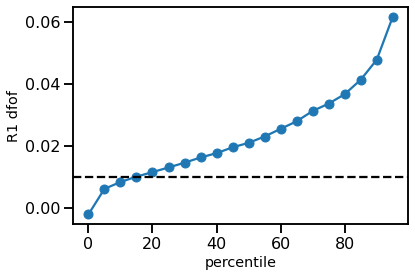

In [81]:
R1_dist = df_tidy[df_tidy.resp_id == 'R1'].groupby('cell_id').dfof.mean().values#.hist(bins=50)

percentile_arr = np.arange(0, 100, 5)
R1_perc = np.percentile(R1_dist, percentile_arr)

plt.plot(percentile_arr, R1_perc, 'o-');
plt.axhline(0.01, color='k', linestyle='--');
plt.xlabel('percentile');
plt.ylabel('R1 dfof');